SVI guide. Run trace. Collect zs. Plot zs against thickness, intensity.

for do(i = 300) what are the values in the output image. Obvs cannot be more than 256.

In [1]:
ROOT_PATH = '../../../../'
# MNIST_DATA_PATH = ROOT_PATH + 'assets/data/morphomnist_reversed_pgm/'
# BASE_LOG_PATH = ROOT_PATH + 'assets/models/morphomnist_reversed_pgm/'

import sys
import os
import inspect
from collections import OrderedDict
from functools import partial

sys.path.append(ROOT_PATH)

import pyro
import torch
import torch.nn.functional as F
import torch_geometric.nn as gnn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
from torch_cluster import grid_cluster

# from torch_geometric.datasets import MNISTSuperpixels

# (root, train=True, transform=None, pre_transform=None, pre_filter=None)

# # from deepscm.datasets.morphomnist.create_synth_intensity_causes_thickness_data import model as true_model
# # from deepscm.experiments import morphomnist_reversed_arrows
# # from deepscm.experiments.morphomnist_reversed_arrows.base_experiment import EXPERIMENT_REGISTRY, MODEL_REGISTRY
# # from deepscm.datasets.morphomnist import MorphoMNISTLike
# # from icl_dl_cw2_utils.utils.plotting import plot_tsne

# torch.autograd.set_grad_enabled(False)

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
%matplotlib inline

## Setup and Data Inspection

In [4]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    
def prep_single_image(batch):
    x = batch['image']
    thickness = batch['thickness'].unsqueeze(0).unsqueeze(0).float()
    intensity = batch['intensity'].unsqueeze(0).unsqueeze(0).float()

    x = x.float()
    x = x.unsqueeze(0).unsqueeze(0)

    return {'x': x, 'thickness': thickness, 'intensity': intensity}

def prep_batch(batch):
    x = batch['image']
    thickness = batch['thickness'].unsqueeze(1).float()
    intensity = batch['intensity'].unsqueeze(1).float()
    x = x.float().unsqueeze(1)
    return {'x': x, 'thickness': thickness, 'intensity': intensity}


class LayerActivations:
    
    def __init__(self, name):
        self.activation = {}
        self.name = name
        
    def __call__(self, model, _input, output):
        self.activation[self.name] = output.detach()
        
    def get_activation(self):
        return self.activation

In [5]:
from torch_geometric.datasets import MNISTSuperpixels
from torchvision.datasets import MNIST

graph_train_dataset = MNISTSuperpixels(root='.', train=True)
image_train_dataset = MNIST(root='.', train=True, download=True)

In [256]:
scale = 32
rescale = 4
offset = torch.FloatTensor([1, 1])
idx = 2

image, _ = image_train_dataset[idx]
image = np.array(image)
data = graph_train_dataset[idx]

In [257]:
data.batch = None

In [258]:
data.to(device)

Data(edge_index=[2, 1384], pos=[75, 2], x=[75, 1], y=[1])

In [259]:
data.y

tensor([4], device='cuda:0')

In [260]:
_graph.shape, adj.shape, position.shape

(torch.Size([75, 1]), torch.Size([62, 62]), torch.Size([62, 2]))

In [261]:
from torch_geometric.nn.pool.consecutive import consecutive_cluster
from torch_geometric.nn.pool import max_pool, max_pool_x

size = 3
grid_size = data['pos'].new(2).fill_(size)
cluster = grid_cluster(data['pos'], grid_size).contiguous()
pooled_data = max_pool(cluster, data)
pooled_img, index, position = pooled_data['x'], pooled_data['edge_index'], pooled_data['pos']
n = position.size(0)

In [262]:
pooled_img.shape, index.shape, position.shape

(torch.Size([60, 1]), torch.Size([2, 870]), torch.Size([60, 2]))

In [263]:
adj = torch.sparse_coo_tensor(index, torch.ones(index.size(1)).to(device), [n, n])

In [264]:
offset = torch.FloatTensor([(28 - position[:, 0].max()) / 2,
                            (28 - position[:, 1].max()) / 2])

In [265]:
position *= (scale * offset).to(device)
position += (scale * offset * rescale).to(device)

In [266]:
from skimage.color import gray2rgb
from PIL import Image, ImageDraw

In [267]:
image = np.ones((28, 28), np.uint8)
image = np.repeat(image, scale * rescale, axis=0)
image = np.repeat(image, scale * rescale, axis=1)
image = gray2rgb(image, alpha=True)
image *= np.array([255, 255, 255, 1], np.uint8)
image = Image.fromarray(image)
draw = ImageDraw.Draw(image)

<ipython-input-267-5bf2aee1e172>:4: FutureWarning: alpha argument is deprecated and will be removed in version 0.19. Please use the gray2rgba function insteadto obtain an RGBA image.
  image = gray2rgb(image, alpha=True)


In [268]:
index = adj._indices().t()

for i in range(index.size(0)):
    start, end = index[i]
    start_x, start_y = position[start]
    end_x, end_y = position[end]
    start_x, start_y = int(start_x), int(start_y)
    end_x, end_y = int(end_x), int(end_y)

    draw.line(
        (start_x, start_y, end_x, end_y),
        fill=(0, 0, 0, 255),
        width=rescale * 2)

In [269]:
for i in range(n):
    x, y = position[i]
    r = 16 * rescale
    draw.ellipse((x - r, y - r, x + r, y + r), fill=(0, 0, 0, 255))
    r = 14 * rescale
    draw.ellipse(
        (x - r, y - r, x + r, y + r), fill=(49, 130, 219, int(255 * pooled_img[i]))
    )

image = image.resize((28 * scale, 28 * scale), Image.ANTIALIAS)

# image.show()

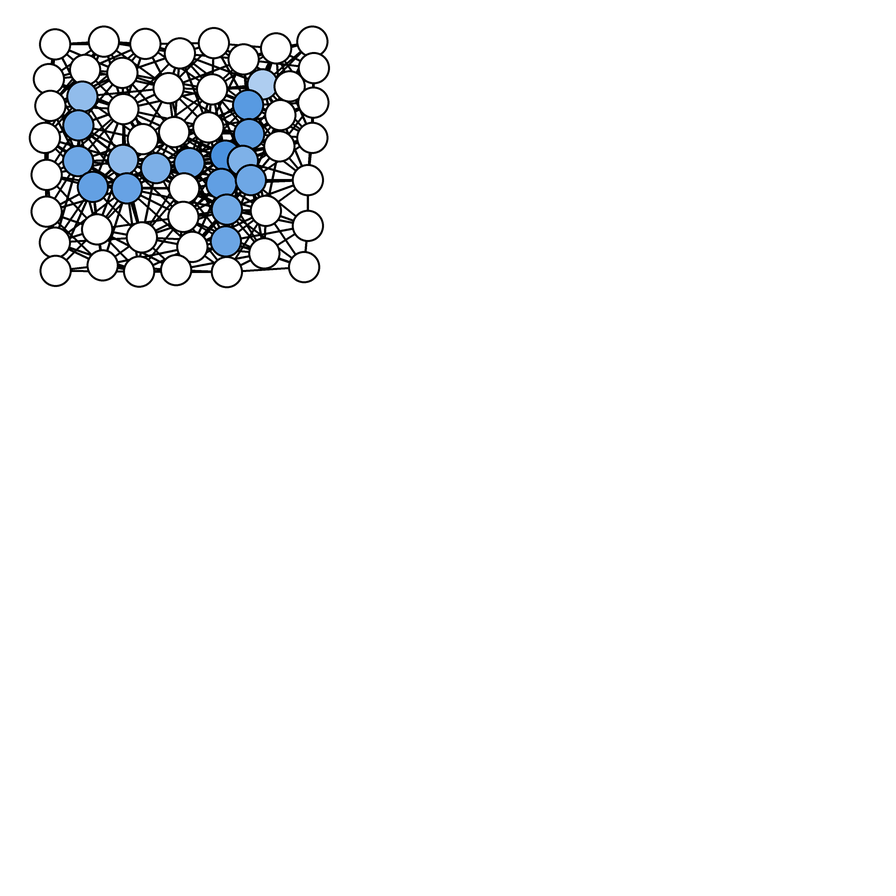

In [270]:
image

## Classifier Model

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = gnn.GCNConv(dataset.num_node_features, 16)
        self.conv2 = gnn.GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)